#Applying LSTM to predict stock price of VNIndex

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Upload data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("drive/MyDrive/Colab Notebooks/Data/Stock Prediction/markets_historical_vnindex_ind.csv", parse_dates = ["Date"]).set_index(["Date"]).filter(["Price"]).sort_values(by=["Date"])
df

,Price
Date,
2002-12-31,183.33
2003-01-02,183.41
2003-01-03,182.39
2003-01-06,181.76
2003-01-07,180.63
...,...
2022-12-26,985.21
2022-12-27,"1,004.57"
2022-12-28,"1,015.66"


In [ ]:
df["Price"] = df["Price"].str.replace(",", "").astype(float)

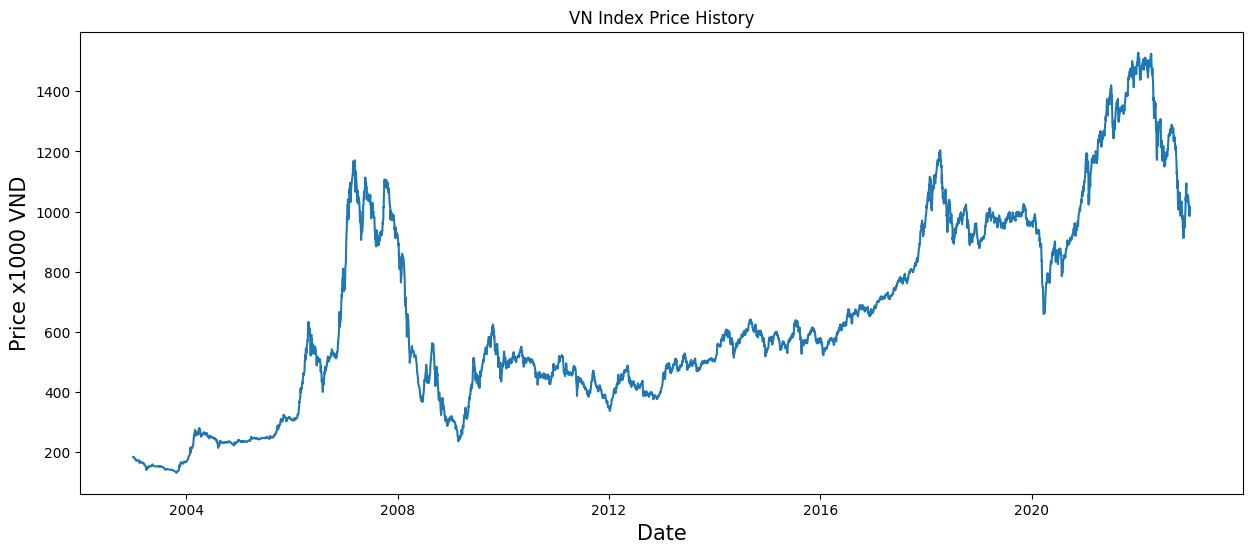

In [ ]:
plt.figure(figsize=(15,6))
plt.title('VN Index Price History')
plt.plot(df['Price'])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price x1000 VND', fontsize=15)
plt.show()

## Preprocessing

In [ ]:
# Normalize data using MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(df.values)
scaled_data

array([[0.03751243],
       [0.03756967],
       [0.03683988],
       ...,
       [0.63302496],
       [0.62846738],
       [0.62689333]])

In [ ]:
# Save the scaler
import joblib
joblib.dump(scaler, "drive/MyDrive/Colab Notebooks/Models/Stock Prediction/scaler.sc")

['drive/MyDrive/Colab Notebooks/Models/Stock Prediction/scaler.sc']

In [ ]:
# Split data
train_data, test_data = np.split(scaled_data, [int(len(scaled_data)*0.9)])
test_data = np.append(train_data[len(train_data)-60:,],test_data)

In [ ]:
# Each query in the training set will contain 60 time-steps and 1 output, which is also the last time step.
X_train = []
y_train = []

for i in range (60,len(train_data)):
  X_train.append(train_data[i-60:i,])
  y_train.append(train_data[i,])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4431, 60, 1)

In [ ]:
len(test_data)

560

## Model


In [ ]:
# Define the model
model = keras.Sequential()

model.add(layers.LSTM(128, return_sequences = True, input_shape=(X_train.shape[1],1)))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences = True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences = False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32))
model.add(layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
139/139 [==============================] - 13s 11ms/step - loss: 0.0040
Epoch 2/10
139/139 [==============================] - 2s 15ms/step - loss: 0.0012
Epoch 3/10
139/139 [==============================] - 2s 15ms/step - loss: 8.7988e-04
Epoch 4/10
139/139 [==============================] - 2s 11ms/step - loss: 7.2160e-04
Epoch 5/10
139/139 [==============================] - 2s 11ms/step - loss: 6.2516e-04
Epoch 6/10
139/139 [==============================] - 2s 11ms/step - loss: 6.0341e-04
Epoch 7/10
139/139 [==============================] - 2s 11ms/step - loss: 5.8231e-04
Epoch 8/10
139/139 [==============================] - 2s 11ms/step - loss: 4.8236e-04
Epoch 9/10
139/139 [==============================] - 2s 11ms/step - loss: 4.8506e-04
Epoch 10/10
139/139 [==============================] - 2s 14ms/step - loss: 4.9640e-04


In [ ]:
model.save("drive/MyDrive/Colab Notebooks/Models/Stock Prediction/stock_prediction.h5")


# Prediction & Evaluation

In [ ]:
# Reshape test data
X_test = []
y_test = []

for i in range (60,len(test_data)):
  X_test.append(test_data[i-60:i,])
  y_test.append(test_data[i,])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(500, 60, 1)

In [ ]:
prediction = model.predict(X_test)
prediction = scaler.inverse_transform(prediction)
prediction[:5]

16/16 [==============================] - 0s 6ms/step


array([[1054.6093],
       [1058.5638],
       [1063.6948],
       [1070.4281],
       [1078.8107]], dtype=float32)

In [ ]:
# Evaluation
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, prediction, squared = False)
rmse

0.038858568554035994

In [ ]:
# Create a dataframe of test data for visualization
test_df = df[len(train_data):]
test_df['Predict'] = prediction
test_df

<ipython-input-30-7b38322057a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predict'] = prediction


,Price,Predict
Date,,
2020-12-31,1103.87,0.660892
2021-01-04,1120.47,0.663722
2021-01-05,1132.55,0.667393
2021-01-06,1143.21,0.672210
2021-01-07,1156.49,0.678208
...,...,...
2022-12-26,985.21,0.622683
2022-12-27,1004.57,0.618329
2022-12-28,1015.66,0.613453


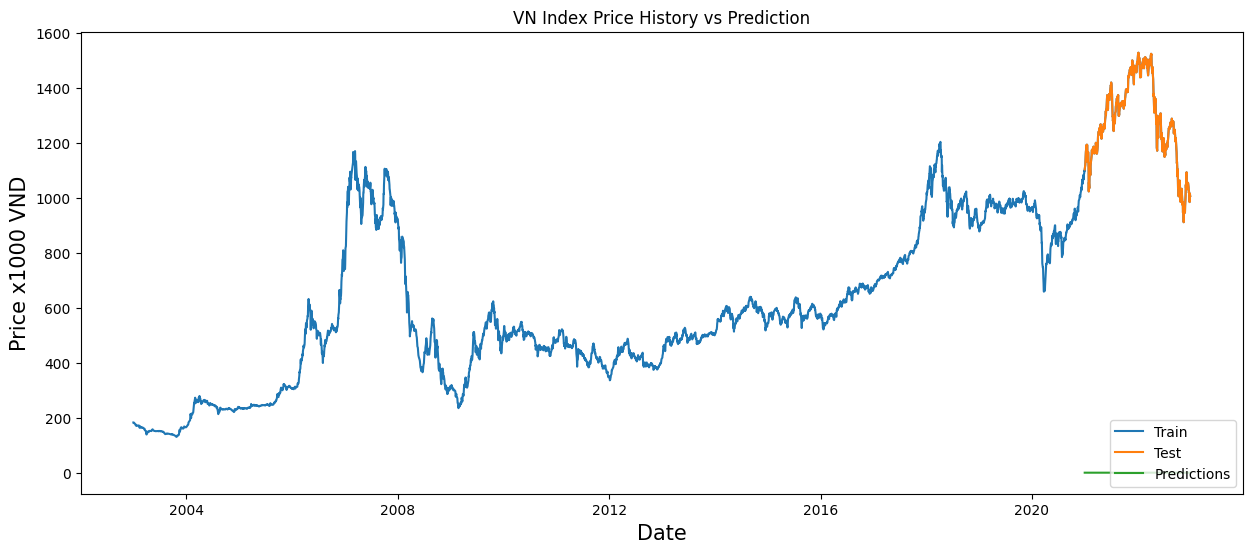

In [ ]:
plt.figure(figsize=(15,6))
plt.title('VN Index Price History vs Prediction')
plt.plot(df['Price'])
plt.plot(test_df[['Price', 'Predict']])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price x1000 VND', fontsize=15)
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

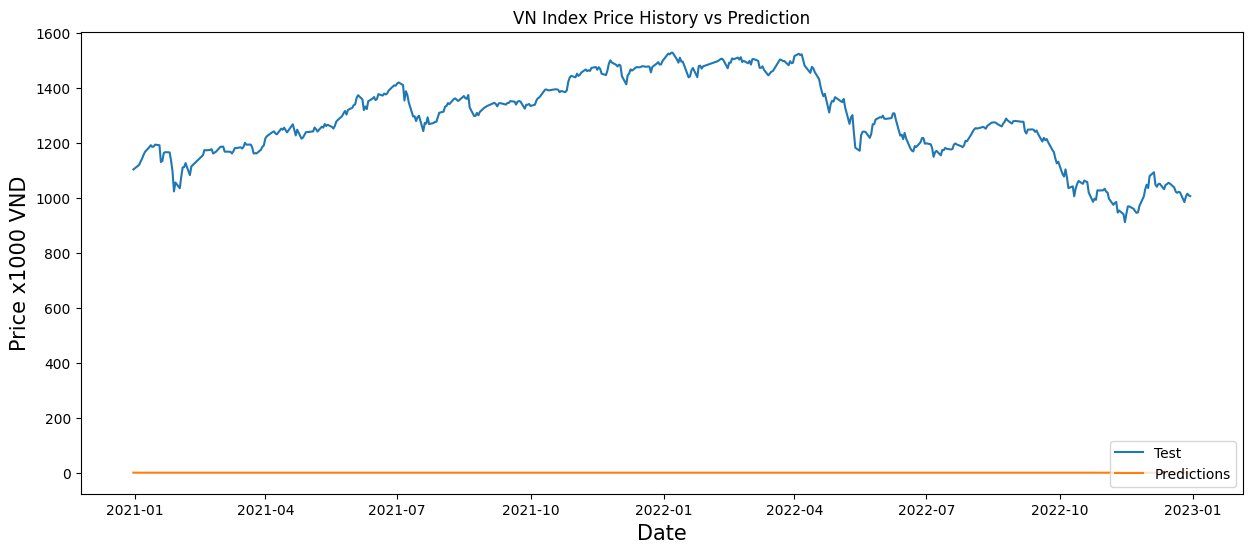

In [ ]:
# compare between test and prediction
plt.figure(figsize=(15,6))
plt.title('VN Index Price History vs Prediction')
plt.plot(test_df[['Price', 'Predict']])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price x1000 VND', fontsize=15)
plt.legend(['Test', 'Predictions'], loc='lower right')
plt.show()